# Completion Rate per session - Segmentación por edad

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1) Cargar el DF
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")

# 2) Definir si se completó la sesión (llegó a 'confirm')
df["completed"] = df["process_step"] == "confirm"

# 3) Crear un DataFrame resumen a nivel de "visit_id" + "variation"
#    Para que cada sesión sea 1 fila:
df_sessions = (df
    .groupby(["visit_id", "variation"], as_index=False)
    .agg({
        "completed": "max",           # 1 si en algún momento hubo 'confirm'
        "clnt_age": "mean",           # si no varía en la misma sesión, 'mean' o 'first' da lo mismo
        "client_id": "first"          # (opcional) para saber a qué cliente está asociado
    })
)

# 4) Crear categoría de edad en este DF resumido
bins = [0, 35, 55, 120]
labels = ["<35", "35-55", ">55"]
df_sessions["age_bin"] = pd.cut(df_sessions["clnt_age"], bins=bins, labels=labels, include_lowest=True)

# 5) Chequear distribution
# print(df_sessions["age_bin"].value_counts(dropna=False))

# 6) Test de hipótesis segmentado por rango de edad
#    Para cada 'age_bin', comparamos la proporción de 'completed' en Test vs. Control
def proportion_test_for_segment(seg_df):
    cr_summary = seg_df.groupby("variation")["completed"].agg(["mean","sum","count"])
    # Chequea que existan ambos grupos
    if not {"Test","Control"}.issubset(cr_summary.index):
        return None

    test_sum = cr_summary.loc["Test","sum"]
    test_n   = cr_summary.loc["Test","count"]
    ctrl_sum = cr_summary.loc["Control","sum"]
    ctrl_n   = cr_summary.loc["Control","count"]
    
    count = np.array([test_sum, ctrl_sum])
    nobs  = np.array([test_n, ctrl_n])
    stat, p_value = sm.stats.proportions_ztest(count, nobs, alternative='two-sided')
    
    return {
        "CR_Test":    cr_summary.loc["Test",    "mean"],
        "CR_Control": cr_summary.loc["Control", "mean"],
        "z_stat":     stat,
        "p_value":    p_value,
        "test_sum":   test_sum,
        "test_n":     test_n,
        "ctrl_sum":   ctrl_sum,
        "ctrl_n":     ctrl_n
    }

alpha = 0.05
age_bins = df_sessions["age_bin"].unique()

for ab in age_bins:
    if pd.isna(ab):
        # Si hay filas sin edad, se ignoran o se gestionan aparte
        continue
    
    seg_df = df_sessions[df_sessions["age_bin"] == ab]
    result = proportion_test_for_segment(seg_df)
    if result is None:
        print(f"Rango edad {ab}: No hay datos suficientes para 'Test' o 'Control'.")
        continue
    
    print(f"=== Rango de Edad: {ab} ===")
    print(f"   Completion Rate (Test)   = {result['CR_Test']:.3%}")
    print(f"   Completion Rate (Control)= {result['CR_Control']:.3%}")
    print(f"   z-stat = {result['z_stat']:.4f}, p-value = {result['p_value']:.6f}")
    
    if result["p_value"] < alpha:
        print("   -> Diferencia significativa (rechazamos H0).")
    else:
        print("   -> No hay diferencia significativa (no rechazamos H0).")
    
    print(f"   [Test completó {int(result['test_sum'])} de {int(result['test_n'])} sesiones]")
    print(f"   [Ctrl completó {int(result['ctrl_sum'])} de {int(result['ctrl_n'])} sesiones]\n")


=== Rango de Edad: >55 ===
   Completion Rate (Test)   = 52.215%
   Completion Rate (Control)= 43.637%
   z-stat = 10.9388, p-value = 0.000000
   -> Diferencia significativa (rechazamos H0).
   [Test completó 4478 de 8576 sesiones]
   [Ctrl completó 3364 de 7709 sesiones]

=== Rango de Edad: <35 ===
   Completion Rate (Test)   = 62.374%
   Completion Rate (Control)= 53.453%
   z-stat = 10.4273, p-value = 0.000000
   -> Diferencia significativa (rechazamos H0).
   [Test completó 4514 de 7237 sesiones]
   [Ctrl completó 3282 de 6140 sesiones]

=== Rango de Edad: 35-55 ===
   Completion Rate (Test)   = 58.415%
   Completion Rate (Control)= 52.816%
   z-stat = 7.3332, p-value = 0.000000
   -> Diferencia significativa (rechazamos H0).
   [Test completó 5373 de 9198 sesiones]
   [Ctrl completó 4136 de 7831 sesiones]



## Gráfico

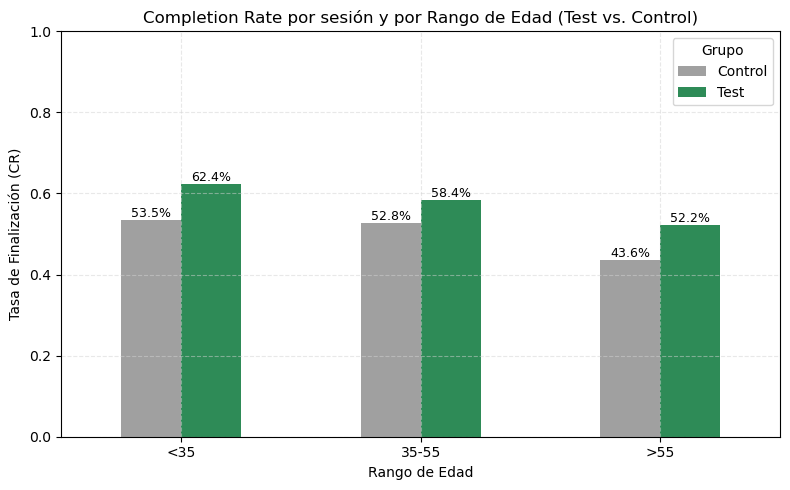

In [5]:
# -------------------------------------------
# PASO 1: Crear un DataFrame con la CR por rango de edad y grupo
# -------------------------------------------
df_cr_by_age = (
    df_sessions
    .groupby(["age_bin", "variation"], observed=False, as_index=False)["completed"]
    .mean()  # mean() = Tasa de finalización (CR) en cada grupo
)

# -------------------------------------------
# PASO 2: Convertir a tabla dinámica para facilitar el gráfico
# -------------------------------------------
df_pivot = df_cr_by_age.pivot(index="age_bin", columns="variation", values="completed")

# -------------------------------------------
# PASO 3: Definir colores
# -------------------------------------------
color_map = {
    "Control": "#A0A0A0",  # Gris neutro
    "Test": "#2E8B57",  # Verde intenso (SeaGreen)
    "Unknown": "gray"
}
# Lista de colores en el orden exacto de las columnas
colors = [color_map.get(col, "gray") for col in df_pivot.columns]

# -------------------------------------------
# PASO 4: Graficar
# -------------------------------------------
ax = df_pivot.plot(
    kind="bar",
    figsize=(8, 5),
    color=colors
)

ax.set_title("Completion Rate por sesión y por Rango de Edad (Test vs. Control)")
ax.set_xlabel("Rango de Edad")
ax.set_ylabel("Tasa de Finalización (CR)")
ax.set_ylim(0, 1)

# --- A) Añadir rejilla (grid) con líneas grises claras ---
ax.grid(True, which='major', axis='both', color='lightgray', alpha=0.5, linestyle='--')

# --- B) Añadir etiquetas con porcentajes encima de cada barra ---
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(
            f"{height:.1%}",  # transformar a porcentaje con 1 decimal
            (p.get_x() + p.get_width()/2, height),
            ha="center",
            va="bottom",
            fontsize=9
        )

# --- C) Leyenda (con valores si fuera necesario, aquí la dejamos indicando grupos) ---
ax.legend(title="Grupo")

plt.xticks(rotation=0)  # Mantener etiquetas de eje X horizontales
plt.tight_layout()
plt.savefig("../../img/cr_age_session.jpg", dpi=300, bbox_inches='tight')
plt.show()
